In [ ]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [ ]:
!pip install mediapipe

In [ ]:
# STEP 1: Import the necessary modules
import os
import numpy as np
import pandas as pd
import cv2 as cv

import matplotlib.pyplot as plt
from google.colab import drive

import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# base_dir = "/content/drive/MyDrive/Colab Notebooks/raw_data/"
base_dir = "/content/drive/MyDrive/Colab Notebooks/TestDataJC/Raw_data"

In [ ]:
# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

In [ ]:
def load_data(directory, detector, num_landmarks=478):
    columns = [f'{coord}{i}' for i in range(1, num_landmarks + 1) for coord in ('x', 'y', 'z')]
    columns.append('y')  # Add the new column for the target feature
    data_df = pd.DataFrame(columns=columns)
    incorrect = []

    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                cv_mat = cv.imread(file_path)
                if cv_mat is None:
                    print(f"Failed to load image {file_path}")
                    continue
                image = mp.Image.create_from_file(file_path)
                detection_result = detector.detect(image)
                all_landmarks = []
                for landmark_coords in detection_result.face_landmarks:
                    for landmark in landmark_coords:
                        all_landmarks.extend([landmark.x, landmark.y, landmark.z])
                if len(all_landmarks) != num_landmarks * 3:
                    incorrect.append(file_path)
                    continue
                # y_value = 1 if 'Stroke' in folder_path else 0
                y_value = 1 if folder == 'Stroke' else 0
                all_landmarks.append(y_value)
                data_df.loc[len(data_df)] = all_landmarks
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue
    return data_df, incorrect


In [ ]:
# Function to perform model fitting and evaluation
def fit_evaluate_model(X_train_pca, y_train, X_test_pca, y_test):
    # Initialize XGBoost classifier
    xgb_clf = xgb.XGBClassifier()
    # Train the model
    xgb_clf.fit(X_train_pca, y_train)
    # Make predictions
    y_pred = xgb_clf.predict(X_test_pca)
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# Load and process data
base_dir = "/content/drive/MyDrive/Colab Notebooks/TestDataJC/Raw_data"
detector = vision.FaceLandmarker.create_from_options(options)  # Assuming options are already defined

train_dir = os.path.join(base_dir, 'processed_train')
test_dir = os.path.join(base_dir, 'processed_test')

train_df, incorrect_train = load_data(train_dir, detector)
test_df, incorrect_test = load_data(test_dir, detector)

X_train, y_train = train_df.drop('y', axis=1), train_df['y']
X_test, y_test = test_df.drop('y', axis=1), test_df['y']

In [ ]:
# Assuming X_test and y_test are your testing features and labels
indices = np.arange(len(X_test))  # Use len(X_test) to get the number of rows
np.random.shuffle(indices)

# Use .iloc for positional indexing
X_test_shuffled = X_test.iloc[indices]
y_test_shuffled = y_test.iloc[indices]

In [ ]:
train_df.shape

(1520, 1435)

In [ ]:
train_df.head(20)

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x476,y476,z476,x477,y477,z477,x478,y478,z478,y
0,0.466898,0.694636,-0.089376,0.472526,0.544410,-0.188417,0.470066,0.585873,-0.097815,0.444964,...,0.680870,0.231076,0.020034,0.639650,0.264088,0.019994,0.678214,0.301145,0.019997,0.0
1,0.476405,0.669267,-0.124511,0.473567,0.479664,-0.206317,0.475609,0.537979,-0.113856,0.441067,...,0.689131,0.181443,0.034835,0.648109,0.215701,0.034792,0.685830,0.252509,0.034797,0.0
2,0.483052,0.555449,-0.180550,0.479879,0.358313,-0.228458,0.483369,0.435642,-0.151730,0.438890,...,0.701111,0.167271,-0.012481,0.662155,0.194024,-0.012526,0.701979,0.227724,-0.012519,0.0
3,0.623102,0.665402,-0.088928,0.579067,0.545793,-0.209366,0.590386,0.576472,-0.099172,0.497898,...,0.651726,0.159798,0.002435,0.627452,0.210869,0.002383,0.680136,0.231629,0.002390,0.0
4,0.483443,0.688945,-0.081814,0.491518,0.560183,-0.215808,0.487376,0.591033,-0.103182,0.458098,...,0.724187,0.219839,-0.002718,0.677410,0.258111,-0.002769,0.721736,0.300188,-0.002763,0.0
5,0.498119,0.696433,-0.086631,0.490377,0.540292,-0.201398,0.492682,0.582605,-0.098925,0.448683,...,0.669170,0.197183,-0.001969,0.630013,0.235471,-0.002014,0.670992,0.271280,-0.002011,0.0
6,0.348990,0.508224,-0.053808,0.335665,0.443520,-0.130050,0.338961,0.461494,-0.060917,0.297665,...,0.421513,0.256523,0.000658,0.401202,0.279833,0.000623,0.431263,0.295223,0.000629,0.0
7,0.483479,0.640073,-0.128475,0.479314,0.444504,-0.214987,0.480083,0.505732,-0.120431,0.443333,...,0.666632,0.174491,0.054033,0.624280,0.209359,0.053982,0.663395,0.247855,0.053990,0.0
8,0.496508,0.678690,-0.076089,0.501372,0.555820,-0.195867,0.497693,0.585462,-0.099169,0.470917,...,0.679594,0.246370,0.000704,0.640327,0.279131,0.000662,0.677107,0.314740,0.000663,0.0
9,0.506558,0.660545,-0.120896,0.504070,0.487869,-0.205540,0.503693,0.540674,-0.111158,0.463408,...,0.696296,0.163553,0.050600,0.655709,0.202439,0.050552,0.699697,0.238938,0.050559,0.0


In [ ]:
test_df.shape

(200, 1435)

In [ ]:
X_train.shape

(1520, 1434)

In [ ]:
X_test.shape

(200, 1434)

In [ ]:
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

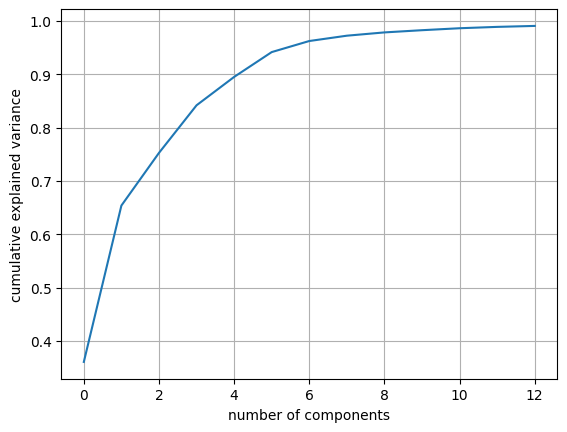

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()

In [ ]:
# Perform hyperparameter tuning and evaluation
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.3, 0.7]
}

In [ ]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='recall', n_jobs=-1, cv=5)

grid_search.fit(X_train_pca, y_train)

y_pred = grid_search.predict(X_test_pca)

# Optimal model evaluation
best_xgb_clf = grid_search.best_estimator_
fit_evaluate_model(X_train_pca, y_train, X_test_pca, y_test)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Accuracy: 0.73

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.39      0.56        88
         1.0       0.67      1.00      0.81       112

    accuracy                           0.73       200
   macro avg       0.84      0.69      0.68       200
weighted avg       0.82      0.73      0.70       200



In [ ]:
# Optimal model evaluation
best_xgb_clf = grid_search.best_estimator_

fit_evaluate_model(X_train_pca, y_train, X_test_pca, y_test)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Accuracy: 0.73

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.39      0.56        88
         1.0       0.67      1.00      0.81       112

    accuracy                           0.73       200
   macro avg       0.84      0.69      0.68       200
weighted avg       0.82      0.73      0.70       200

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


In [ ]:
# # Initialize XGBoost classifier
# xgb_clf = xgb.XGBClassifier()

# # Train the model
# xgb_clf.fit(X_train_pca, y_train)

# # Make predictions
# y_pred = xgb_clf.predict(X_test_pca)

# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))